In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Load and view the data

In [2]:
users_df = pd.read_csv('takehome_users.csv',encoding='latin-1')
engagement_df = pd.read_csv('takehome_user_engagement.csv',encoding='latin-1')

In [3]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Explore the users dataset

In [5]:
users_df.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [6]:
users_df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [7]:
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'], format='%Y%m%d %H:%M:%S.%f')
users_df['creation_time'].dtype

dtype('<M8[ns]')

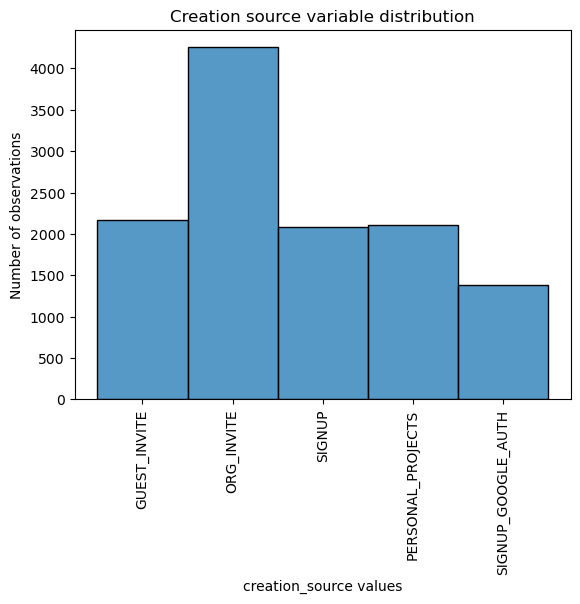

In [8]:
sns.histplot(users_df, x='creation_source')
plt.xticks(rotation=90)
plt.title('Creation source variable distribution')
plt.xlabel('creation_source values')
plt.ylabel('Number of observations')
plt.show()

### Explore the engagement dataset

In [9]:
engagement_df.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [10]:
engagement_df.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [11]:
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'], format='%Y%m%d %H:%M:%S.%f')
engagement_df['time_stamp'].dtype

dtype('<M8[ns]')

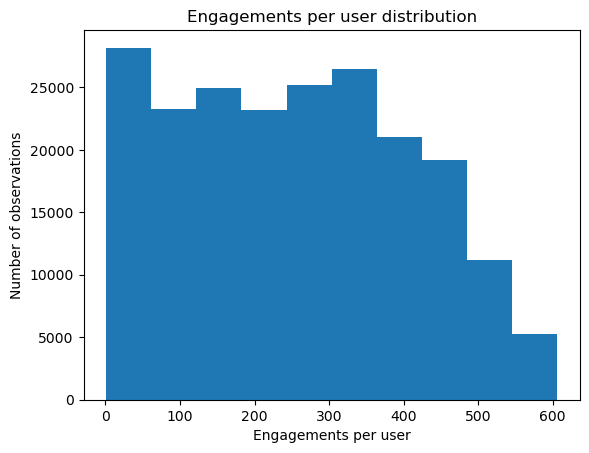

In [12]:
grouped = engagement_df.groupby('user_id')['user_id'].transform('count')
grouped.plot.hist()
plt.title('Engagements per user distribution')
plt.xlabel('Engagements per user')
plt.ylabel('Number of observations')
plt.show()

### Preprocessing and Modeling

In [13]:
#Find adopted user with the criteria of atleast 3 visits on seperate days in a given week
engagement_df['wk'] = engagement_df['time_stamp'].dt.week
df = engagement_df.groupby(['wk','user_id'])['time_stamp'].count().reset_index(name="freq")

result = df[df.freq >= 3]
user_ids = result.user_id.tolist()
users_df['adopted_user'] = [(idx in user_ids) for idx in users_df['object_id']]

C:\Users\manth\AppData\Local\Temp\ipykernel_17368\2240671994.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  engagement_df['wk'] = engagement_df['time_stamp'].dt.week


In [14]:
#clean up users_df
users_df.drop(['name','email','creation_time'],axis=1,inplace=True)
users_df.fillna(0,inplace=True)
users_df['creation_source'] = users_df['creation_source'].map({'PERSONAL_PROJECTS': 1, 'GUEST_INVITE': 2,'ORG_INVITE': 3,'SIGNUP': 4,'SIGNUP_GOOGLE_AUTH': 5})
users_df['adopted_user'] = users_df['adopted_user'].map({True: 1, False:0})
users_df.set_index('object_id', inplace=True)
users_df.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
object_id,,,,,,,
1,2,1.398139e+09,1,0,11,10803.0,0
2,3,1.396238e+09,0,0,1,316.0,1
3,3,1.363735e+09,0,0,94,1525.0,0
4,2,1.369210e+09,0,0,1,5151.0,0
5,2,1.358850e+09,0,0,193,5240.0,0


In [15]:
X = users_df.drop('adopted_user', axis=1)
y = users_df['adopted_user']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3483
           1       0.71      0.59      0.65       477

    accuracy                           0.92      3960
   macro avg       0.83      0.78      0.80      3960
weighted avg       0.92      0.92      0.92      3960



The classification report shows that the Random Forest model fits very well to the data and accurately predicts adopted users

Text(0.5, 1.0, 'Random Forest Feature Importance')

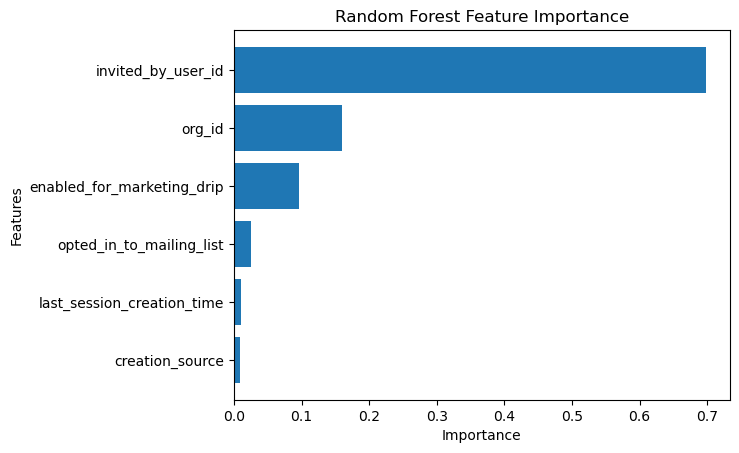

In [18]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns, rf.feature_importances_[sorted_idx])
plt.xlabel("Importance")
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')

According to the Random Forest model, the key predictors of 'adopted_user' are 'invited_by_user_id', 'org_id', and 'enabled_for_marketing_drip'